In [317]:
import numpy as np
import matplotlib.pyplot as plt
from open_atmos_jupyter_utils import show_plot, show_anim
from PyMPDATA import ScalarField, Solver, Stepper, VectorField, Options, boundary_conditions
from mpl_toolkits.mplot3d import Axes3D
from math import pi, e
import math as mh
from mpl_toolkits.mplot3d import Axes3D

In [318]:
class ShallowWaterEquationsIntegrator:
    def __init__(self, *, h_initial: np.ndarray, options: Options = None, bathymetry: np.ndarray):
        """ initializes the solvers for a given initial condition of `h` assuming zero momenta at t=0 """
        options = options or Options(nonoscillatory=True, infinite_gauge=True)
        X, Y, grid = 0, 1, h_initial.shape
        stepper = Stepper(options=options, grid=grid, n_threads=1)
        kwargs = {
            'boundary_conditions': [boundary_conditions.Constant(value=0)] * len(grid), #Powtarzamy tę listę len(grid) razy
            'halo': options.n_halo,
        }
        advectees = {
            "h": ScalarField(h_initial, **kwargs), #**kwargs, w ten sposób rozpakowujesz słownik kwargs, czyli do wszystkich trzech jest przekazane boundary_conditions = boundary_conditions.Constant... i halo = options.n_halo
            "uh": ScalarField(np.zeros(grid), **kwargs),
            "vh": ScalarField(np.zeros(grid), **kwargs),
        }
        self.advector = VectorField((
                np.zeros((grid[X] + 1, grid[Y])),
                np.zeros((grid[X], grid[Y] + 1))
            ), **kwargs
        )
        self.solvers = { k: Solver(stepper, v, self.advector) for k, v in advectees.items() }
        self.bathymetry = bathymetry
    def __getitem__(self, key):
        """ returns `key` advectee field of the current solver state """
        return self.solvers[key].advectee.get()
    
    def _apply_half_rhs(self, *, key, axis, g_times_dt_over_dxy):
        """ applies half of the source term in the given direction """
        self[key][:] -= .5 * g_times_dt_over_dxy * self['h'] * np.gradient(self['h']-self.bathymetry, axis=axis)

    def _update_courant_numbers(self, *, axis, key, mask, dt_over_dxy):
        """ computes the Courant number component from fluid column height and momenta fields """
        velocity = np.where(mask, np.nan, 0)
        momentum = self[key]
        np.divide(momentum, self['h'], where=mask, out=velocity)

        # using slices to ensure views (over copies)
        all = slice(None, None) 
        all_but_last = slice(None, -1)
        all_but_first_and_last = slice(1, -1)

        velocity_at_cell_boundaries = velocity[( 
            (all_but_last, all),
            (all, all_but_last),
        )[axis]] + np.diff(velocity, axis=axis) / 2 
        courant_number = self.advector.get_component(axis)[(
            (all_but_first_and_last, all),
            (all, all_but_first_and_last)
        )[axis]]
        courant_number[:] = velocity_at_cell_boundaries * dt_over_dxy[axis]
        assert np.amax(np.abs(courant_number)) <= 1

    def __call__(self, *, nt: int, g: float, dt_over_dxy: tuple, outfreq: int, eps: float=1e-7):
        """ integrates `nt` timesteps and returns a dictionary of solver states recorded every `outfreq` step[s] """
        output = {k: [] for k in self.solvers.keys()}
        for it in range(nt + 1): 
            if it != 0:
                mask = self['h'] > eps
                for axis, key in enumerate(("uh", "vh")): #axis to najpierw 0, potem 1, a key, to najpierw uh, a potem vh
                    self._update_courant_numbers(axis=axis, key=key, mask=mask, dt_over_dxy=dt_over_dxy)
                self.solvers["h"].advance(n_steps=1)
                for axis, key in enumerate(("uh", "vh")):
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
                    self.solvers[key].advance(n_steps=1)
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
            if it % outfreq == 0:
                for key in self.solvers.keys():
                    output[key].append(self[key].copy())
        return output

# Opis układu i parametry początkowe

Analizie poddałem układ, odpowiadający dnu oceanicznemu. Stworzyłem model przekroju takiego dna, które ma szelfy kontynentalne z lewej i prawej strony. Niedaleko srodka znajduje się grzbiet oceaniczny, natomiast po jego lewej stronie strefa subdukcji, gdzie znajduje się rów oceaniczny. Niniejszy przekrój jest wzdłuż osi y. Rozciągnąłem go wzdłuż osi x, aby utrzorzyć dwuwymiarowy układ. Na środku osi x głębokość rowu i wysokość grzbietu są największe, natomiast bliżej brzegów zaczynają się redukować, aż ich wielkość spada niemal do zera. Na poniższym rysunku przedstawiono przekrój wzdłuż osi y dla środka osi x. Pod tym wykresem znajduje się funkcja mnożnik, przez jaką zostały przemnożone kolejne przekroje w zależności od y.

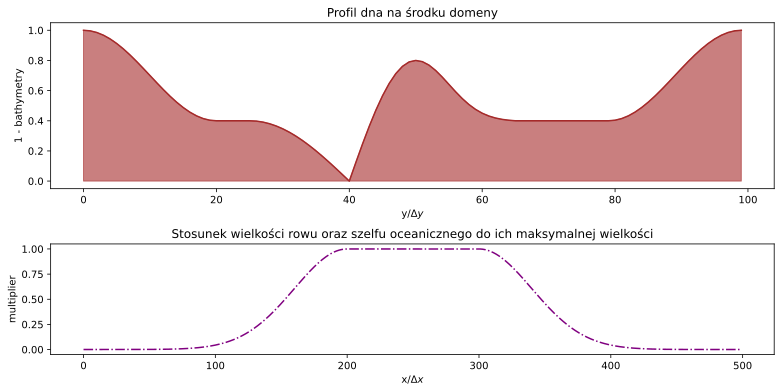

In [319]:
plateau_height = 0.4
ridge_height = 2*plateau_height
shore_width_ratio = .1

def make_bathy_slice(grid1, disturbance_ratio:float= 1): 
    X = np.linspace(0, grid1[1] - 1, grid1[1])   
    bathy_slice = np.ones(grid1[1])*plateau_height
    shore_width = X[int(shore_width_ratio*grid1[1])]

    middle_shore_X_left = X[int(shore_width_ratio*grid1[1])]
    mask = np.array(X <= middle_shore_X_left + shore_width)
    bathy_slice += (np.cos(X*pi/2/shore_width)/2 + .5)*(1-plateau_height)*mask

    middle_shore_X_right = X[int((1 - shore_width_ratio)*grid1[1])]
    mask = np.array(X >= middle_shore_X_right - shore_width)
    bathy_slice += (np.cos((X - X[-1])*pi/2/shore_width)/2 + .5)*(1-plateau_height)*mask

    trench_X_ratio = .4
    ridge_X_ratio = .5
    trench_X_width_ratio = .15
    ridge_X_width_ratio = .15

    trench_X = X[int(trench_X_ratio*grid1[1])]
    ridge_X = X[int(ridge_X_ratio*grid1[1])]
    trench_X_width = X[int(trench_X_width_ratio*grid1[1])]
    ridge_X_width = X[int(ridge_X_width_ratio*grid1[1])]

    mask = np.array(X >= trench_X - trench_X_width)*np.array(X <= trench_X)
    bathy_slice += ( ( (np.cos((X - trench_X + trench_X_width)*pi/2/trench_X_width) - 1) *plateau_height )*mask )*disturbance_ratio

    mask = np.array(X <= ridge_X)*np.array(X > trench_X)
    bathy_slice += ( ( (np.cos((X - ridge_X)*pi/2/(ridge_X - trench_X)) - 1) *ridge_height + plateau_height )*mask )*disturbance_ratio

    mask = np.array(X > ridge_X)*np.array(X <= ridge_X + ridge_X_width)
    gauss_height = plateau_height/( 1 - (e**(-(ridge_X_width)**2/(2*(ridge_X_width/3)**2))) )
    gauss_offset = e**(-(ridge_X_width)**2/(2*(ridge_X_width/3)**2))
    bathy_slice += ( ( (e**(-(X - ridge_X)**2/(2*(ridge_X_width/3)**2)) - gauss_offset) *gauss_height)*mask )*disturbance_ratio

    bathy_slice = 1 - bathy_slice
    return bathy_slice

grid1 = (500, 100)
X = np.linspace(0, grid1[1] - 1, grid1[1])
Y = np.linspace(0, grid1[0] - 1, grid1[0])

ridge_Y_beggining_ratio = .4
ridge_Y_end_ratio = 1 - ridge_Y_beggining_ratio
ridge_Y_beggining = Y[int(ridge_Y_beggining_ratio*grid1[0])]
ridge_Y_end = Y[int(ridge_Y_end_ratio*grid1[0])]
ridge_Y_width = ridge_Y_beggining.copy()

disturbance_ratio = np.zeros(grid1[0])
mask = np.array(Y <= ridge_Y_beggining)
disturbance_ratio += e**( -(Y - ridge_Y_beggining)**2/(2*(ridge_Y_width/5)**2) )*mask

mask = np.array(Y >= ridge_Y_end)
disturbance_ratio += e**( -(Y - ridge_Y_end)**2/(2*(ridge_Y_width/5)**2) )*mask

mask = np.array(Y < ridge_Y_end)*np.array(Y > ridge_Y_beggining)
disturbance_ratio += 1*mask

fig, axs = plt.subplots(nrows=2, ncols=1, figsize= (13, 6),
                        gridspec_kw={'height_ratios': [1.5, 1]})
axs[0].plot(X, 1- make_bathy_slice(grid1), color= 'brown')
axs[0].fill_between(X, 1- make_bathy_slice(grid1), 0, color= 'brown', alpha= .6)
axs[1].plot(Y, disturbance_ratio, color= 'purple', ls= '-.')
axs[0].set_title('Profil dna na środku domeny')
axs[1].set_title('Stosunek wielkości rowu oraz szelfu oceanicznego do ich maksymalnej wielkości')
axs[0].set_xlabel(r'y/$\Delta y$')
axs[0].set_ylabel(r'1 - bathymetry')
axs[1].set_xlabel(r'x/$\Delta x$')
axs[1].set_ylabel(r'multiplier')
plt.subplots_adjust(hspace=0.4) 

show_plot('0')

#bathymetry = np.tile(make_bathy_slice(), (grid1[0], 1))

Poniżej znajduje się lista matematycznych funkcji użytych do wygenerowania kształtu dna:

- Szelfy kontynentalne: przy pomocy połówek okrsów funkcji cosinus
- Lewe zbocze rowu oceanicznego: ćwiartka okresu funkcji cosinus
- Prawe zbocze rowu oceanicznego i lewe zbocze grzbietu oceanicznego: ćwiartka okresu funkcji cosinus
- Prawe zbocze grzbietu oceanicznego: Częsć prawej strony krzywej Gaussa
- Funkcja mnożnik: W środkowej części jest stała a zbocza to lewa i prawa strona krzywej Gaussa

Celem projektu jest symulacja fali tsunami, dlatego nalezy określić odpowiednie warunki początkowe. Aby to zrobić załozyłem, że doszło doprzesunięcia płyt tektonicznych, w taki sposób, że płyta z lewej strony obniżyła się, a z prawej podniosła. Warunek początkowy wygenerowałem przenosząc na powierzchnię wody kształt dna ocenicznego i mnożc go przez 0.06. Na poniższym rysunku przedstawiony został trójwymiarowy model dna oraz kształt zadanego warunku początkowego.

In [320]:
bathymetry1 = np.zeros((grid1[0], grid1[1]))
for i, ratio in enumerate(disturbance_ratio):
    bathymetry1[i] = make_bathy_slice(grid1, ratio)

delta_h_initial1 = bathymetry1.copy()
delta_h_initial1 *= 0
delta_h_initial1 += .0
for i in range(int(.2*grid1[1]), int((1-.3)*grid1[1])):
    mask = (bathymetry1[:,i] < 1 - (plateau_height + 1/5*ridge_height) )
    delta_h_initial1[:,i] += (bathymetry1[:,i] - 1 + plateau_height - 0*(plateau_height + 1/5*ridge_height))#*mask
delta_h_initial1 *= .06

x = np.linspace(0, grid1[1], grid1[1])
y = np.linspace(0, grid1[0], grid1[0])
x, y = np.meshgrid(x, y)

fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw=dict(projection='3d'), figsize= (14,8))
z = 1 - bathymetry1
surf1 = ax[0].plot_surface(x, y, z, cmap='magma')
ax[0].set_xlabel(r'y/$\Delta$y')
ax[0].set_ylabel(r'x/$\Delta$x')
ax[0].set_zlabel('1 - bathymetry')
ax[0].view_init(elev=20, azim=-100)
cmap = fig.colorbar(surf1, pad= 0.1, shrink= 0.6)
z = 0 - delta_h_initial1
surf2 = ax[1].plot_surface(x, y, z, cmap='winter')
ax[1].set_xlabel(r'y/$\Delta$y')
ax[1].set_ylabel(r'x/$\Delta$x')
ax[1].set_zlabel('0 - initial')
cmap = fig.colorbar(surf2, pad= 0.1, shrink= 0.6)

ax[0].set_title('Wygenerowane dno')
ax[1].set_title('Początkowe wzbudzneie ośrodka płynnego')

show_plot('1')

Postanowiłem odpowiedziećna nastepujące pytanie: Czy wysokość przy brzegu fali tsunami powstałej w powyżej opisany sposób zależy od tego czy przyszła od strony rowu lub grzbietu oceanicznego?

In [321]:
h_initial1 = bathymetry1.copy()
h_initial1 -= delta_h_initial1

output1 = ShallowWaterEquationsIntegrator(
    h_initial=h_initial1, bathymetry=bathymetry1
)(
    nt=130, g=10, dt_over_dxy=(.15, .15), outfreq=1
)

In [322]:
grid2 = (1000, 200)

X = np.linspace(0, grid2[1] - 1, grid2[1])
Y = np.linspace(0, grid2[0] - 1, grid2[0])

ridge_Y_beggining_ratio = .4
ridge_Y_end_ratio = 1 - ridge_Y_beggining_ratio
ridge_Y_beggining = Y[int(ridge_Y_beggining_ratio*grid2[0])]
ridge_Y_end = Y[int(ridge_Y_end_ratio*grid2[0])]
ridge_Y_width = ridge_Y_beggining.copy()

disturbance_ratio = np.zeros(grid2[0])
mask = np.array(Y <= ridge_Y_beggining)
disturbance_ratio += e**( -(Y - ridge_Y_beggining)**2/(2*(ridge_Y_width/5)**2) )*mask

mask = np.array(Y >= ridge_Y_end)
disturbance_ratio += e**( -(Y - ridge_Y_end)**2/(2*(ridge_Y_width/5)**2) )*mask

mask = np.array(Y < ridge_Y_end)*np.array(Y > ridge_Y_beggining)
disturbance_ratio += 1*mask

bathymetry2 = np.zeros((grid2[0], grid2[1]))
for i, ratio in enumerate(disturbance_ratio):
    bathymetry2[i] = make_bathy_slice(grid2, ratio)

delta_h_initial2 = bathymetry2.copy()
delta_h_initial2 *= 0
delta_h_initial2 += .0
for i in range(int(.2*grid2[1]), int((1-.3)*grid2[1])):
    mask = (bathymetry2[:,i] < 1 - (plateau_height + 1/5*ridge_height) )
    delta_h_initial2[:,i] += (bathymetry2[:,i] - 1 + plateau_height - 0*(plateau_height + 1/5*ridge_height))#*mask
delta_h_initial2 *= .06

h_initial2 = bathymetry2.copy()
h_initial2 -= delta_h_initial2

output2 = ShallowWaterEquationsIntegrator(
    h_initial=h_initial2, bathymetry=bathymetry2
)(
    nt=260, g=10, dt_over_dxy=(.15, .15), outfreq=1
)

# Wyniki
Symulacje przeprowadziałem najpierw dla siatki $500 \times 100$ i liczby chwil czasowych $n_t = 130$. Nastęonie podwoiłem rozdzielczość przestzrenną i czasową; kolejną symulację uruchomiłem dla siatki $1000 \times 200$ oraz $n_t = 260$. W obydwu przypadkach ustawiłem $\frac{dt}{dx} = \frac{dt}{dy} = 0.15$. Na poniższym rysunku widać, mapy wysokości swobodnej powierzchni względem geoidy $\zeta$ w ostatniej chwili czasowej symulacji. Dla mniejzej rozdzielczości widoczne są silniejsze zafalowania, co świadczy bardziej zanczących błędach numerycznych, niż w przypadku większej rozdzielczosci, dla której powierzchnia płynu jest gładsza.

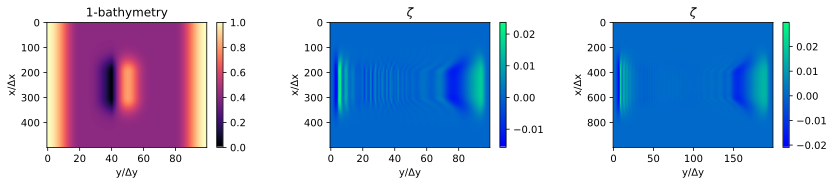

In [323]:
fig, ax = plt.subplots(nrows= 1, ncols= 3, figsize= (12, 3))
surf1 = ax[0].imshow(1-bathymetry1, aspect= 'auto', cmap= 'magma')
ax[0].set_title('1-bathymetry')
ax[0].set_xlabel(r'y/$\Delta$y')
ax[0].set_ylabel(r'x/$\Delta$x')
fig.colorbar(surf1)

surf2 = ax[1].imshow(output1['h'][-1]-bathymetry1, aspect= 'auto', cmap= 'winter')
ax[1].set_xlabel(r'y/$\Delta$y')
ax[1].set_ylabel(r'x/$\Delta$x')
ax[1].set_title(r'$\zeta$')
fig.colorbar(surf2)

surf2 = ax[2].imshow(output2['h'][-1]-bathymetry2, aspect= 'auto', cmap= 'winter')
ax[2].set_xlabel(r'y/$\Delta$y')
ax[2].set_ylabel(r'x/$\Delta$x')
ax[2].set_title(r'$\zeta$')
fig.colorbar(surf2)

plt.tight_layout(pad=2.0)

show_plot('2')

Na następnym rysunku znajduje się przekrój $\zeta$ wzdłuż osi y w środku osi x. Tutaj również wyraźnie widać, że dla zmniejszej rozdzielczości pojawiają się znaczące artefakty. Najbardziej znaczące zaburzenia znajdują się po lewej; od strony rowu oceanicznego. Od strony grzbietu fale są znacznie gładsze.

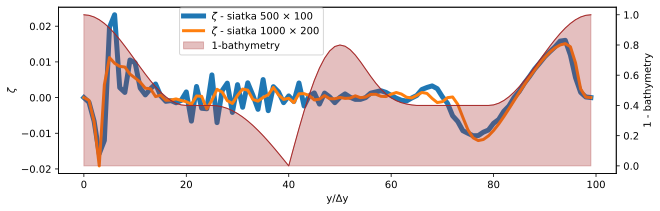

In [324]:
fig, ax = plt.subplots(nrows= 1, ncols= 1, figsize= (10, 3))

ax.plot(np.array(output1['h'][-1][grid1[0] // 2])-bathymetry1[grid1[0] // 2], zorder= 2, 
        label= rf'$\zeta$ - siatka {grid1[0]} $\times$ {grid1[1]}',
        linewidth= 5)
ax.plot(np.array(output2['h'][-1][grid2[0] // 2])[::2]-bathymetry2[grid2[0] // 2][::2], zorder= 2, 
        label= rf'$\zeta$ - siatka {grid2[0]} $\times$ {grid2[1]}',
        ls= '-', linewidth= 3)

ax1 = ax.twinx()
ax1.plot(1- bathymetry1[grid1[0] // 2], color= 'brown', linewidth = 1, zorder = 1)

ax1.fill_between(X[:len(X)//2], 1- bathymetry1[grid1[0] // 2], 0, color= 'brown', linewidth = 1, zorder= 1, alpha= .3, label= '1-bathymetry')
ax.set_xlabel(r'y/$\Delta$y')
ax.set_ylabel(r'$\zeta$')
ax1.set_ylabel(r'1 - bathymetry')
fig.legend(bbox_to_anchor=(0.5, 0.9))

show_plot('3')

Analizując powyższy rysunek można odpowiedzieć na postawione wcześniej pytanie. Na przykłądzie gęstszej siatki widać, że fala jest znacznie wyższa przy prawym brzegu, tj. od strony grzbietu oceanicznego.

Przeanalizowano także pola wektorowe prędkości płynu, które przedstawiono na poniższym rysunku. Dla obydwu rozdzielczości pola są do siebie podobne od strony grzbietu, natomiast od strony rowu pojawiają się znaczące rozbieżności. Dla mniejszej rozdzielczości tym obszarze wiele wektorów jest znacznie większych niż ich odpowiedniki dla większej rozdzielczości.

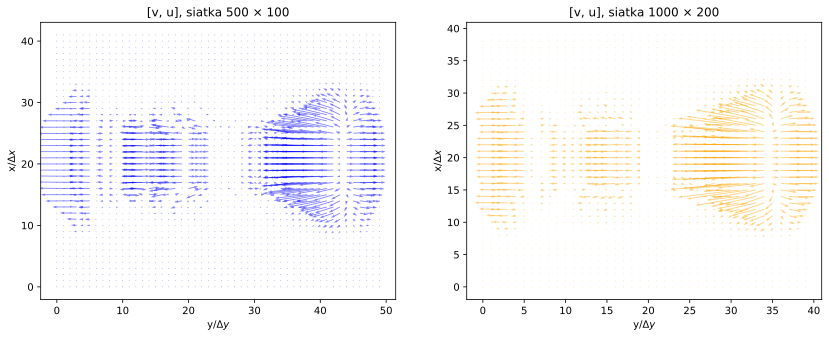

In [325]:
fig,ax = plt.subplots(1, 2, figsize= (14,5))
downsampling1x, downsampling1y = 12, 2
ax[0].quiver(output1['vh'][-1][::downsampling1x, ::downsampling1y], output1['uh'][-1][::downsampling1x, ::downsampling1y], 
          alpha= .5, color= 'blue')
ax[0].set_xlabel(r'y/$\Delta y$')
ax[0].set_ylabel(r'x/$\Delta x$')
ax[0].set_title(fr'[v, u], siatka {grid1[0]} $\times$ {grid1[1]}')
downsampling2x, downsampling2y = 25, 5
ax[1].quiver(output2['vh'][-1][::downsampling2x, ::downsampling2y], output2['uh'][-1][::downsampling2x, ::downsampling2y], 
          alpha= .5, color= 'orange')
ax[1].set_xlabel(r'y/$\Delta y$')
ax[1].set_ylabel(r'x/$\Delta x$')
ax[1].set_title(fr'[v, u], siatka {grid2[0]} $\times$ {grid2[1]}')

show_plot('4')

In [326]:
# def plot(frame, *, zlim=(-.25, .25)):
#     psi = output['h'][frame]-bathymetry
#     xi, yi = np.indices(psi.shape)
#     fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12, 6))
#     ax.plot_wireframe(xi+.5, yi+.5, psi, color='blue', linewidth=.5, zorder= 2)
#     ax.set(zlim=zlim, proj_type='ortho', title=f"t / Δt = {frame}", zlabel=r"$\zeta$")
#     for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
#         axis.pane.fill = False
#         axis.pane.set_edgecolor('black')
#         axis.pane.set_alpha(1)
#     for axis in ('x', 'y'):
#         getattr(ax, f'set_{axis}label')(f"{axis} / Δ{axis}")
#     plt.colorbar(
#         ax.contourf(xi+.5, yi+.5, bathymetry, zdir='z', offset=zlim[0]),
#         pad=.1, aspect=10, fraction=.02, label='bathymetry', location='left', cmap= 'magma'
#     ).ax.invert_yaxis()
#     return fig
# show_anim(plot, range(len(output['h'])), gif_file= 'płotka.gif')

# UWAGI
Dopisac krótkie podsumowanie (1 str)

Autor sprawka w nagłówku
